# PiML Outcome Analysis

- Prediction Accuracy

- Hyperparameter Tuning

- Weakness Detection

- Overfitting Analysis

- Prediction Uncertainty

- Robustness Test

- Resilience Test

- Bias and Fairness


In [ ]:
!pip install piml

## 0) Example Data and Model

In [1]:
from piml import Experiment
exp = Experiment()
exp.data_loader(data="SimuCredit")

(CVXPY) May 13 04:48:17 AM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.7.2996). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) May 13 04:48:17 AM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.7.2996). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')


,Mortgage,Balance,Amount Past Due,Credit Inquiry,Open Trade,Delinquency,Utilization,Gender,Race,Approved
0,196153.90,2115.19,0.00,0,0,0,0.759069,1,0,1
1,149717.49,2713.77,1460.57,1,1,1,0.402820,1,0,1
2,292626.34,2209.01,0.00,0,0,0,0.684272,1,1,1
3,264812.52,21.68,0.00,0,0,0,0.037982,0,0,0
4,236374.39,1421.49,1290.85,0,0,2,0.231110,1,1,1
...,...,...,...,...,...,...,...,...,...,...
19995,236123.54,3572.34,0.00,0,0,0,0.896326,1,1,0
19996,374572.72,3560.24,0.00,0,0,0,0.648893,1,1,0
19997,279238.55,101.75,0.00,0,0,0,0.068079,0,1,0
19998,149678.27,439.46,214.36,1,0,2,0.311219,0,0,1


In [2]:
# Data Preparation
exp.data_summary(feature_exclude=["Gender", "Race"], silent=True)
exp.data_prepare(target="Approved", task_type="classification", silent=True)

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

In [3]:
# Build XGBoost model with max_depth 3
from xgboost import XGBClassifier
model = XGBClassifier(max_depth=3, n_estimators=1000,
                      learning_rate=0.01, random_state=0)
exp.model_train(model, name="XGB-default")

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

In [4]:
from sklearn.neural_network import MLPClassifier
model = MLPClassifier(hidden_layer_sizes=[20]*4,
                      activation="relu", random_state=0)
exp.model_train(model, name='MLP-default')

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

In [5]:
# Build benchmark models XGB2 and GAMI-Net

from piml.models import XGB2Classifier
from piml.models import GAMINetClassifier
exp.model_train(model=XGB2Classifier(n_estimators = 1000, eta = 0.01,
                                     mono_increasing_list=("Balance", ),
                                     mono_decreasing_list=("Utilization", )), name="XGB2")
exp.model_train(model=GAMINetClassifier(mono_increasing_list=("Balance", ),
                                     mono_decreasing_list=("Utilization", )), name="GAMI-Net")

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

## 1) Prediction Accuracy

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

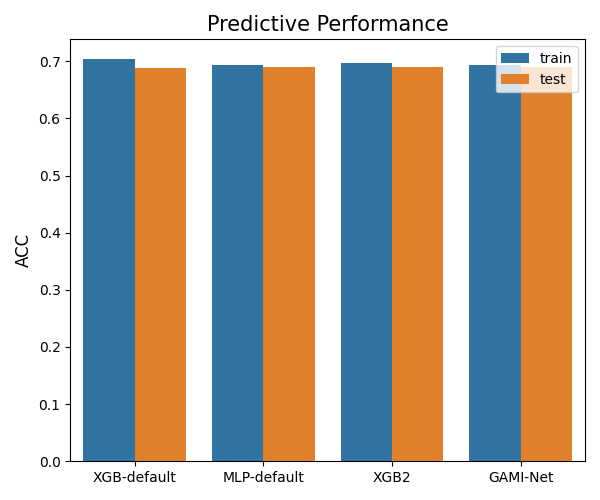

In [7]:
exp.model_compare(models=["XGB-default", "MLP-default", "XGB2", "GAMI-Net"],
                  show="accuracy_plot", metric="ACC",
                  figsize=(6,5))

In [8]:
exp.model_diagnose(model="XGB-default", show='accuracy_table')

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

,ACC,AUC,F1,LogLoss,Brier
,,,,,
Train,0.7033,0.7722,0.7265,0.5676,0.1931
Test,0.6890,0.7564,0.7153,0.5845,0.1997
Gap,-0.0143,-0.0158,-0.0112,0.0169,0.0066


In [9]:
result = exp.segmented_diagnose(model="XGB-default", show="segment_table", segment_feature="Mortgage",
                       segment_method="uniform", segment_bins = 10, return_data=True)

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

,Segment ID,Feature,Segment,Size,ACC
0,0,Mortgage,"[0.6005, 0.6668]",2,0.500000
1,1,Mortgage,"[0.5343, 0.6005)",6,0.500000
2,2,Mortgage,"[0.0042, 0.0705)",1279,0.641908
3,3,Mortgage,"[0.0705, 0.1367)",1373,0.690459
4,4,Mortgage,"[0.1367, 0.203)",770,0.716883
5,5,Mortgage,"[0.203, 0.2693)",335,0.740299
6,6,Mortgage,"[0.2693, 0.3355)",141,0.758865
7,7,Mortgage,"[0.468, 0.5343)",9,0.777778
8,8,Mortgage,"[0.3355, 0.4018)",56,0.785714
9,9,Mortgage,"[0.4018, 0.468)",29,0.862069


In [10]:
result = exp.segmented_diagnose(model="XGB-default", show="segment_table", segment_feature="Mortgage",
                       segment_method="quantile", segment_bins = 10, return_data=True)

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

,Segment ID,Feature,Segment,Size,ACC
0,0,Mortgage,"[0.0042, 0.0335)",400,0.635000
1,1,Mortgage,"[0.0501, 0.0664)",400,0.640000
2,2,Mortgage,"[0.0335, 0.0501)",400,0.652500
3,3,Mortgage,"[0.0664, 0.0841)",400,0.652500
4,4,Mortgage,"[0.0841, 0.1016)",400,0.677500
5,5,Mortgage,"[0.1465, 0.1782)",400,0.690000
6,6,Mortgage,"[0.1216, 0.1465)",400,0.715000
7,7,Mortgage,"[0.1016, 0.1216)",400,0.727500
8,8,Mortgage,"[0.1782, 0.2317)",400,0.730000
9,9,Mortgage,"[0.2317, 0.6668]",400,0.770000


## 2) Hyperparameter Tuning

In [14]:
# Hyperparameter Tuning with Grid Search
parameters = {'max_depth': [1, 2, 3, 4, 5, 6, 7, 8]}
result = exp.model_tune(model="XGB-default",
                        method="grid",
                        parameters=parameters,
                        metric=['AUC', 'LogLoss'],
                        test_ratio=0.4,
                        random_state=0)
result.data

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

,Rank(by AUC),AUC,LogLoss,time
params,,,,
{'max_depth': 3},1,0.752090,0.588135,0.850630
{'max_depth': 2},2,0.751441,0.588816,0.666868
{'max_depth': 4},3,0.749131,0.591288,1.045171
{'max_depth': 5},4,0.747925,0.593690,1.306149
{'max_depth': 6},5,0.743697,0.599636,1.714214
{'max_depth': 7},6,0.741206,0.603746,5.586551
{'max_depth': 8},7,0.735205,0.612239,2.983575
{'max_depth': 1},8,0.732021,0.606960,0.472600


HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

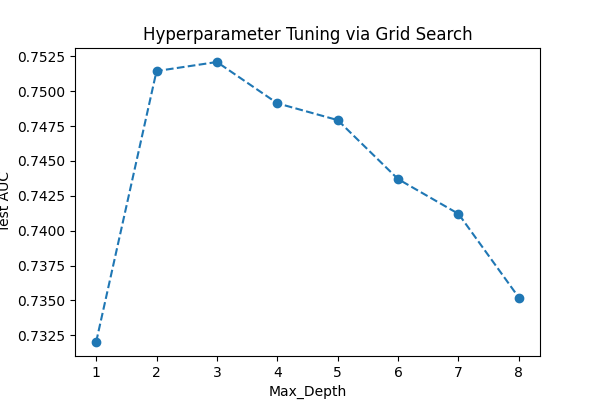

In [15]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(np.arange(1, 1+result.data.shape[0]), result.cv_results_["mean_test_AUC"], '--o')
plt.xlabel("Max_Depth")
plt.ylabel("Test AUC")
plt.title("Hyperparameter Tuning via Grid Search")
plt.show()

In [16]:
import scipy
parameter_space = {'max_depth': [1, 2, 3, 4, 5, 6, 7, 8],
                   'n_estimators': scipy.stats.randint(100, 2000),
                   'learning_rate': scipy.stats.loguniform(0.001, 1.0)}
result = exp.model_tune(model="XGB-default",
                        method="randomized",
                        parameters=parameter_space,
                        metric=["AUC", "LogLoss"],
                        n_runs=100,
                        test_ratio=0.4,
                        random_state=0)
# result.data

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

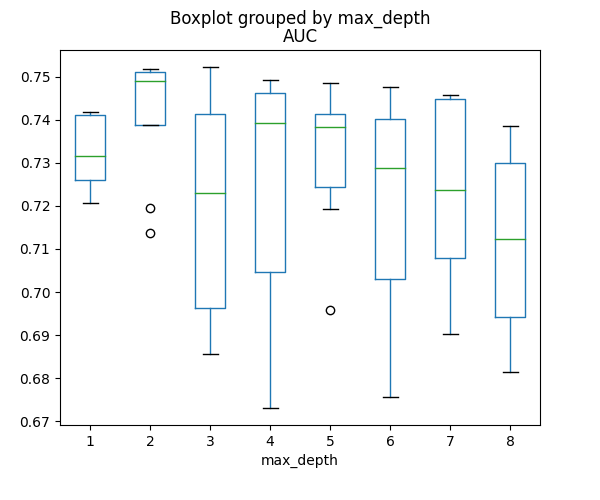

In [17]:
import pandas as pd
df = pd.concat([pd.DataFrame(result.cv_results_['params']),
                pd.DataFrame(result.cv_results_["mean_test_AUC"], columns=["AUC"]),
                pd.DataFrame(result.cv_results_["mean_test_LogLoss"], columns=["LogLoss"])], axis=1)
df.boxplot(column=['AUC'], by='max_depth', grid=False, figsize=(6, 5))
plt.show()

## 3) Weakness Detection

In [ ]:
# Choose XGB-default: WeakSpot, 1D (Delinquency) with ACC/Threshold 1.0; 2D (Deliquency, Utilization) with ACC/Threshold 1.1
exp.model_diagnose()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

## 4) Overfitting Analysis

In [ ]:
# Benign Overfitting Phenomenon
import pandas as pd
import numpy as np
from matplotlib import pylab as plt
from sklearn.metrics import roc_auc_score

feature_names = exp.get_feature_names()
target_name = exp.get_target_name()ridr
train_x, train_y, _ = exp.get_data(train=True)
test_x, test_y, _ = exp.get_data(test=True)

def score(model, iteration_range):
    train_auc = roc_auc_score(train_y, model.predict_proba(train_x, iteration_range=iteration_range)[:, 1])
    test_auc = roc_auc_score(test_y, model.predict_proba(test_x, iteration_range=iteration_range)[:, 1])
    tree_idx = np.logical_and(xgbinfo["Tree"] < iteration_range[1], xgbinfo["Tree"] >= iteration_range[0])
    n_leaves = np.sum(xgbinfo[tree_idx].loc[:, ["Feature"]].values == "Leaf")
    return {'n_leaves': n_leaves, 'n_iteration': iteration_range[1], 'train_auc': train_auc, 'test_auc': test_auc}

all_metrics = []
model = exp.get_model("XGB-default").estimator
xgbinfo = model.get_booster().trees_to_dataframe()
for i in range(0, model.get_num_boosting_rounds(), 5):
    metrics = score(model, (0, i + 1))
    all_metrics.append(metrics)
all_resluts = pd.DataFrame(all_metrics)
all_resluts = pd.DataFrame(all_metrics)

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

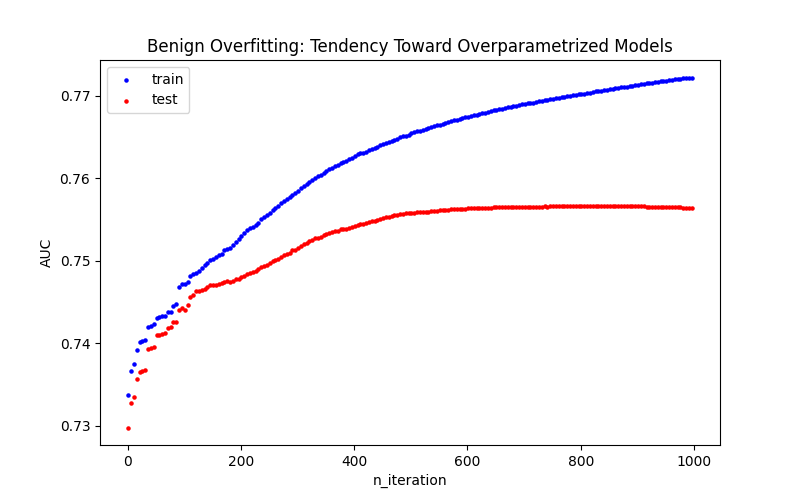

In [ ]:
plt.figure(figsize=(8,5))
plt.scatter(all_resluts["n_iteration"], all_resluts["train_auc"], label="train", color="blue", s=5)
plt.scatter(all_resluts["n_iteration"], all_resluts["test_auc"], label="test", color="red",  s=5)
plt.legend()
plt.ylabel("AUC")
plt.xlabel("n_iteration")
plt.title("Benign Overfitting: Tendency Toward Overparametrized Models")
plt.show()

In [ ]:
# Choose XGB-default, XGB2, GAMI-Net: Overfit (Delinquency, AUC)
exp.model_compare()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

## 5) Prediction Uncertainty

In [ ]:
# Choose XGB-default, Reliablity: Bandwidth Threshold = 1
exp.model_diagnose()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

## 6) Robustness Test

In [ ]:
# Choose XGB-default, XGB2, GAMI-Net: Overfit (Delinquency, AUC)
exp.model_compare()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

## 7) Reslience Test

In [ ]:
# Choose XGB-default, Reliablity: Bandwidth Threshold = 1
exp.model_diagnose()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

## 8) Bias and Fairness

In [ ]:
exp.model_fairness_compare()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

In [18]:
exp.model_fairness()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…